<a href="https://colab.research.google.com/github/nikita-0209/ml_quark_gluon/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

We chose this as given the performance of LDA, SGD, it seemed that the data is not linearly separable.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
labels = np.load("/content/drive/MyDrive/lhc/nopid_rTrue_pFalse_tTrue_tw1.0_cf_False_maskTrue_cmaskFalse_nc_100_MD_1000_DF_1000_NH_4_NL_4_NHL_2_temp_0.10_opt_adam_bsize_128_lr_0.00005_SB_1.0_N_1jetclr_labs_1.npy")

In [ ]:
reps = np.load("/content/drive/MyDrive/lhc/nopid_rTrue_pFalse_tTrue_tw1.0_cf_False_maskTrue_cmaskFalse_nc_100_MD_1000_DF_1000_NH_4_NL_4_NHL_2_temp_0.10_opt_adam_bsize_128_lr_0.00005_SB_1.0_N_1jetclr_reps_1.npy")[:, 0]

In [ ]:
labels_train, labels_test, reps_train, reps_test = train_test_split(labels, reps, test_size=0.33, random_state=69)

In [ ]:
model = RandomForestClassifier()

# Fit on training data
model.fit(reps_train, labels_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Stats about the trees in random forest
n_nodes = []
max_depths = []
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 17740
Average maximum depth 92


In [ ]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(reps_train)
train_rf_probs = model.predict_proba(reps_train)[:, 1]

In [ ]:
# Testing predictions (to determine performance)
y_pred = model.predict(reps_test)
rf_probs = model.predict_proba(reps_test)[:, 1]

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Normalized confusion matrix
[[0.75964806 0.24035194]
 [0.28989104 0.71010896]]


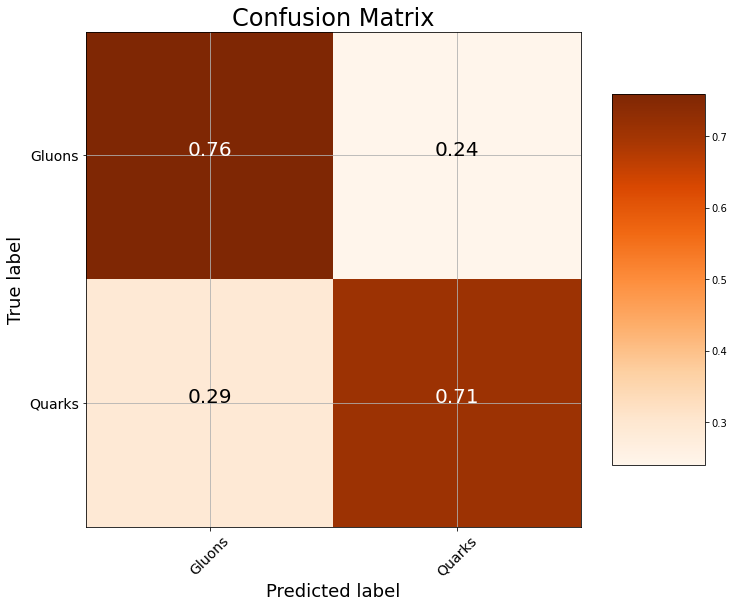

In [ ]:
cm = confusion_matrix(labels_test, y_pred)
# 0 for gluons and 1 for quarks
plot_confusion_matrix(cm, classes = ['Gluons', 'Quarks'],
                      title = 'Confusion Matrix')

In [ ]:
accuracy_score(labels_test, y_pred)

0.7348484848484849

Recall Baseline: 1.0 Test: 0.71 Train: 1.0
Precision Baseline: 0.5 Test: 0.75 Train: 1.0
Roc Baseline: 0.5 Test: 0.8 Train: 1.0


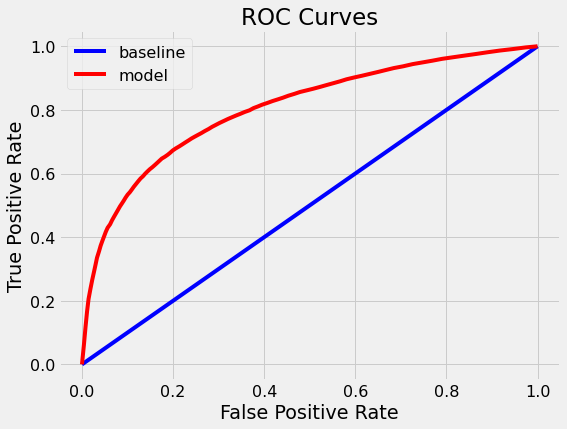

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(labels_test, 
                                     [1 for _ in range(len(labels_test))])
    baseline['precision'] = precision_score(labels_test, 
                                      [1 for _ in range(len(labels_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(labels_test, predictions)
    results['precision'] = precision_score(labels_test, predictions)
    results['roc'] = roc_auc_score(labels_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(labels_train, train_predictions)
    train_results['precision'] = precision_score(labels_train, train_predictions)
    train_results['roc'] = roc_auc_score(labels_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(labels_test, [1 for _ in range(len(labels_test))])
    model_fpr, model_tpr, _ = roc_curve(labels_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(y_pred, rf_probs, train_rf_predictions, train_rf_probs)